### Basic Codes

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

def load_and_preprocess_mfcc(classCSVPath, label_encoder=None):
    """Loads and preprocesses MFCC data, optionally using an existing label_encoder."""
    mfcc_df = pd.read_csv(classCSVPath)

    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(mfcc_df["Label"]) #Fit the encoder with all the unique labels.
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])
    else:
        # Check for new classes and update the encoder if necessary
        new_classes = set(mfcc_df["Label"].unique()) - set(label_encoder.classes_)
        for new_class in new_classes:
            label_encoder.classes_ = np.append(label_encoder.classes_, new_class)
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])

    mfcc_features = mfcc_df.iloc[:, 3:].values
    labels = mfcc_df["Label"].values

    scaler = StandardScaler()
    mfcc_features = scaler.fit_transform(mfcc_features)
    mfcc_features = mfcc_features.reshape(mfcc_features.shape[0], mfcc_features.shape[1], 1)

    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))

    return mfcc_features, labels_one_hot, label_encoder


def load_and_preprocess_spectrogram(spectrogram_paths, label_encoder):
    """Loads and preprocesses spectrogram data."""

    def _load_spectrogram_image(path):  # Inner helper function
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
        corrected_path = os.path.abspath(os.path.join(BASE_DIR, path))
        if os.path.exists(corrected_path):
            img = load_img(corrected_path, target_size=(224, 224), color_mode='rgb')
            img = img_to_array(img) / 255.0
            return img, os.path.basename(os.path.dirname(corrected_path))
        else:
            print(f"Warning: Spectrogram not found at {corrected_path}")
            return None, None  # Or raise an exception if you prefer

    images = []
    labels = []
    for path in spectrogram_paths:
        img, label = _load_spectrogram_image(path)
        if img is not None:  # Check if image was loaded successfully
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = label_encoder.transform(labels) # Use the same LabelEncoder
    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))
    return images, labels_one_hot

def apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder):
    """Applies data augmentation and SMOTE to spectrogram data."""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train_spectrogram)  # Fit BEFORE SMOTE

    unique_classes = np.unique(np.argmax(y_train_spectrogram, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_spectrogram.reshape(X_train_spectrogram.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_spectrogram, axis=1))
        X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)  # Reshape back
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_spectrogram.")
        X_train_resampled, y_train_resampled = X_train_spectrogram, y_train_spectrogram  # Use original data

    return X_train_resampled, y_train_resampled, datagen


def apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder):
    """Applies SMOTE to MFCC data."""
    unique_classes = np.unique(np.argmax(y_train_mfcc, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_mfcc, axis=1))
        X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_mfcc.")
        X_train_resampled, y_train_resampled = X_train_mfcc, y_train_mfcc  # Use original data

    return X_train_resampled, y_train_resampled


def SplitDataset(classCSVPath, label_encoder=None):
    """Main function to split and preprocess the dataset."""

    mfcc_features, y_mfcc, label_encoder = load_and_preprocess_mfcc(classCSVPath, label_encoder)
    spectrogram_paths = pd.read_csv(classCSVPath)["Spectrogram_Path"].values

    X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, train_indices, test_indices = train_test_split(
        mfcc_features, y_mfcc, range(len(y_mfcc)), test_size=0.3, random_state=37, stratify = np.argmax(y_mfcc, axis=1) # Stratify based on original labels
    )

    X_train_spectrogram_paths = spectrogram_paths[train_indices]
    X_test_spectrogram_paths = spectrogram_paths[test_indices]

    X_train_spectrogram, y_train_spectrogram = load_and_preprocess_spectrogram(X_train_spectrogram_paths, label_encoder)
    X_test_spectrogram, y_test_spectrogram = load_and_preprocess_spectrogram(X_test_spectrogram_paths, label_encoder)


    X_train_spectrogram_resampled, y_train_spectrogram_resampled, datagen = apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder)
    X_train_mfcc_resampled, y_train_mfcc_resampled = apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder)

    return X_train_mfcc_resampled, y_train_mfcc_resampled, X_test_mfcc, y_test_mfcc, \
           X_train_spectrogram_resampled, y_train_spectrogram_resampled, X_test_spectrogram, y_test_spectrogram, \
           label_encoder, datagen


In [2]:
# base_audio_path = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"

# X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, X_train_spec, y_train_spec, X_test_spec, y_test_spec, label_encoder, datagen = SplitDataset(base_audio_path)


In [3]:
# # Print sample output
# print(f"Sample MFCC Features Shape: {X_test_mfcc.shape}")  # (samples, timesteps, features)
# print(f"Sample Spectrogram Image Shape: {X_test_spec.shape}")  # (samples, 224, 224, 3)
# print(f"Sample Label One-Hot: {y_test_mfcc[12]}")  # Example label
# print(f"Sample Label One-Hot: {y_test_spec[12]}")  # Example label

## CNN

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

class IncrementalCNN:
    def __init__(self, input_shape, num_classes, filters=128, kernel_size=3, learning_rate=0.0002, l2_reg=0.001):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.filters = filters
        self.kernel_size = kernel_size
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg  # Store the L2 regularization value
        self.model = self.build_model()
        self.fisher_matrix = None
        self.previous_weights = None

    def build_model(self):
        input_layer = layers.Input(shape=self.input_shape)
        
        # Convolutional Layers
        conv1 = layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size, activation='relu', padding='same', kernel_regularizer=regularizers.l2(self.l2_reg))(input_layer)
        max_pool1 = layers.MaxPooling1D(pool_size=2)(conv1)
        
        conv2 = layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size, activation='relu', padding='same', kernel_regularizer=regularizers.l2(self.l2_reg))(max_pool1)
        max_pool2 = layers.MaxPooling1D(pool_size=2)(conv2)

        # Flatten and Dense Layers
        flatten = layers.Flatten()(max_pool2)
        dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))(flatten)
        output_layer = layers.Dense(self.num_classes, activation='softmax', kernel_regularizer=regularizers.l2(self.l2_reg))(dense)

        model = models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                      loss=losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model

    def train_initial(self, X_train, y_train, epochs=20, batch_size=32, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        history = self.model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=1)
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.previous_weights = self.model.get_weights()
        self.plot_training_history(history)
        print(self.fisher_matrix)
    
    def calculate_fisher_matrix(self, X_train, y_train_one_hot):
        fisher_matrices = [np.zeros_like(weight.numpy()) for weight in self.model.trainable_weights]

        for i in range(len(X_train)):
            with tf.GradientTape() as tape:
                predictions = self.model(np.expand_dims(X_train[i], axis=0))
                loss = losses.categorical_crossentropy(np.expand_dims(y_train_one_hot[i], axis=0), predictions)

            gradients = tape.gradient(loss, self.model.trainable_weights)
            for j, grad in enumerate(gradients):
                if grad is not None:
                    fisher_matrices[j] += np.square(grad.numpy())

        fisher_matrices = [fisher / len(X_train) for fisher in fisher_matrices]
        self.fisher_matrix = fisher_matrices

    def train_incremental(self, X_train, y_train, epochs=5, batch_size=32, ewc_lambda=7.0, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)

        train_size = int(len(X_train) * (1 - validation_split))
        X_train_train, X_val = X_train[:train_size], X_train[train_size:]
        y_train_train, y_val = y_train_one_hot[:train_size], y_train_one_hot[train_size:]

        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(epochs):
            for batch_start in range(0, len(X_train_train), batch_size):
                batch_end = batch_start + batch_size
                batch_X = X_train_train[batch_start:batch_end]
                batch_y = y_train_train[batch_start:batch_end]

                with tf.GradientTape() as tape:
                    predictions = self.model(batch_X, training=True)
                    loss = losses.categorical_crossentropy(batch_y, predictions)

                    if self.fisher_matrix and self.previous_weights:
                        ewc_loss = 0.0
                        for i, weight in enumerate(self.model.trainable_weights):
                            if weight.shape != self.previous_weights[i].shape:
                                continue
                            ewc_loss += ewc_lambda * tf.reduce_sum(self.fisher_matrix[i] * tf.square(weight - self.previous_weights[i]))
                        loss += ewc_loss

                gradients = tape.gradient(loss, self.model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            train_loss, train_acc = self.model.evaluate(X_train_train, y_train_train, verbose=0)
            val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.4f}")

        self.previous_weights = self.model.get_weights()
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.ewc_plot_training_history(history)
        print("Changed fisher matrix: ", self.fisher_matrix)

    def add_new_label(self, X_train, y_train, X_old=None, y_old=None, epochs=5, batch_size=16, ewc_lambda=5.0):
        print(f"🔵 Adding new label: Current num_classes = {self.num_classes}, Incrementing by 1.")
        self.num_classes += 1

        old_weights = {layer.name: layer.get_weights() for layer in self.model.layers}
        print("✅ Old Weights Stored Successfully!")

        old_output_layer = self.model.layers[-1]
        old_output_weights = old_output_layer.get_weights()
        print(f"✅ Old Output Layer Weights Retrieved")

        new_output_layer = layers.Dense(self.num_classes, activation='softmax', kernel_regularizer=regularizers.l2(self.l2_reg), name='new_output_layer')

        print(f"✅ Created New Output Layer with {self.num_classes} Classes")

        input_tensor = self.model.input
        x = input_tensor
        for i, layer in enumerate(self.model.layers[1:-1]):
            print(f"🔄 Applying layer {i}: {layer.name}")
            try:
                x = layer(x)
            except Exception as e:
                print(f"🚨 Error at layer {i}: {layer.name} - {e}")
                return

        output_tensor = new_output_layer(x)
        self.model = models.Model(inputs=input_tensor, outputs=output_tensor)
        print("✅ Model Architecture Updated Successfully!")

        for layer in self.model.layers[:-1]:
            if layer.name in old_weights:
                layer.set_weights(old_weights[layer.name])
                print(f"✅ Weights Transferred to Layer: {layer.name}")

        new_output_weights = []
        for i, old_w in enumerate(old_output_weights):
            if old_w.ndim == 2:
                new_w = np.concatenate([old_w, np.random.normal(0, 0.01, (old_w.shape[0], 1))], axis=1)
            elif old_w.ndim == 1:
                new_w = np.concatenate([old_w, np.zeros((1,))], axis=0)

            new_output_weights.append(new_w)

        try:
            new_output_layer.set_weights(new_output_weights)
            print("✅ New Output Layer Weights Set Successfully!")
        except ValueError as e:
            print(f"🚨 Weight Assignment Error: {e}")
            return

        self.learning_rate = 0.00015
        self.model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                           loss=losses.CategoricalCrossentropy(),
                           metrics=['accuracy'])
        print("✅ Model Compiled Successfully!")

        y_train_adjusted = y_train + (self.num_classes - 1 - np.max(y_train))
        print(f"🔄 Adjusted Labels: min={y_train_adjusted.min()}, max={y_train_adjusted.max()}")

        if X_old is not None and y_old is not None:
            X_combined = np.concatenate((X_train, X_old), axis=0)
            y_combined = np.concatenate((y_train_adjusted, y_old), axis=0)
            print(f"✅ Combined Data: X shape {X_combined.shape}, y shape {y_combined.shape}")
        else:
            X_combined = X_train
            y_combined = y_train_adjusted
            print(f"✅ Using Only New Data: X shape {X_combined.shape}, y shape {y_combined.shape}")

        self.train_incremental(X_combined, y_combined, epochs, batch_size, ewc_lambda)
        print("🚀 Incremental Training Complete!")

    # def plot_training_history(self, history):
    #     if history is None:
    #         return
    #     plt.figure(figsize=(12, 4))
    #     plt.subplot(1, 2, 1)
    #     plt.plot(history['accuracy'], label='Train Accuracy')
    #     if 'val_accuracy' in history:
    #         plt.plot(history['val_accuracy'], label='Validation Accuracy')
    #     plt.legend()
    #     plt.title('Accuracy')

    #     plt.subplot(1, 2, 2)
    #     plt.plot(history['loss'], label='Train Loss')
    #     if 'val_loss' in history:
    #         plt.plot(history['val_loss'], label='Validation Loss')
    #     plt.legend()
    #     plt.title('Loss')
    #     plt.show()
    def plot_training_history(self, history): 
        if history is None:
            return

        history_dict = history.history  # Extract history as a dictionary

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history_dict.get('accuracy', []), label='Train Accuracy')
        if 'val_accuracy' in history_dict:
            plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history_dict.get('loss', []), label='Train Loss')
        if 'val_loss' in history_dict:
            plt.plot(history_dict['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')

        plt.show()


    def evaluate_model(self, X_test, y_test, label_encoder): #updated function to accept label_encoder
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print(classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(np.unique(y_test))))
        print(f"Test Accuracy: {np.mean(y_pred == y_test)}")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_test)), yticklabels=label_encoder.inverse_transform(np.unique(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def ewc_plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()

             

In [6]:
import pickle

initial_csv_path  = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"
X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, \
X_train_spectrogram, y_train_spectrogram, X_test_spectrogram, y_test_spectrogram, \
label_encoder, datagen = SplitDataset(initial_csv_path)

Final X_train_mfcc shape: (336, 13, 1)
Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.3983 - loss: 1.5337 - val_accuracy: 0.7500 - val_loss: 1.3518
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6769 - loss: 1.3360 - val_accuracy: 0.7941 - val_loss: 1.1697
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6982 - loss: 1.1969 - val_accuracy: 0.8235 - val_loss: 1.0027
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7470 - loss: 1.0261 - val_accuracy: 0.8676 - val_loss: 0.8507
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8051 - loss: 0.8523 - val_accuracy: 0.8676 - val_loss: 0.7477
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7928 - loss: 0.7818 - val_accuracy: 0.8971 - val_loss: 0.6914
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8979 - loss: 0.6692 - val_accuracy: 0.9265 - val_loss: 0.6297
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9400 - loss: 0.6618 - v

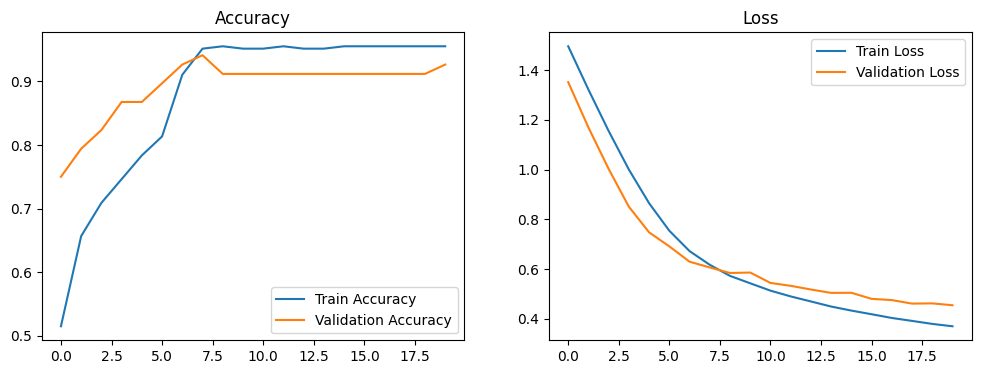

[array([[[0.00274813, 0.00282985, 0.00891986, 0.00233074, 0.00382517,
         0.00672876, 0.00764708, 0.00584087, 0.00452489, 0.00153197,
         0.0014156 , 0.00268812, 0.00699185, 0.01152208, 0.00527349,
         0.02596084, 0.00852409, 0.00335857, 0.004248  , 0.00635359,
         0.00288104, 0.00468028, 0.01000561, 0.00158546, 0.01149728,
         0.01530625, 0.00544576, 0.00736104, 0.01214591, 0.00535771,
         0.00585348, 0.00246701, 0.00422559, 0.0155274 , 0.01966891,
         0.01447249, 0.00395085, 0.00123323, 0.00842068, 0.00480353,
         0.00489733, 0.00673647, 0.00641336, 0.0112641 , 0.00545275,
         0.00856321, 0.00068175, 0.00650723, 0.00716923, 0.01360683,
         0.0041747 , 0.00777286, 0.00376146, 0.00923626, 0.01522505,
         0.00178682, 0.00879929, 0.00397452, 0.01019541, 0.00665722,
         0.01678204, 0.0110673 , 0.00170223, 0.00464725, 0.00254369,
         0.00716907, 0.0017371 , 0.003526  , 0.00569278, 0.0157939 ,
         0.00984914, 0.00584791, 

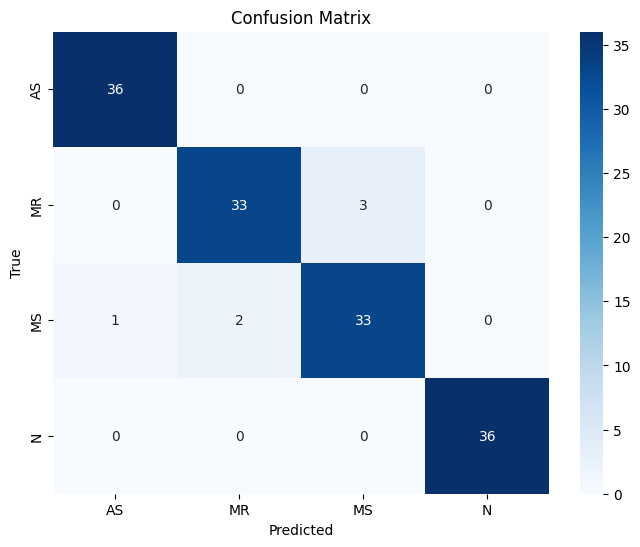

In [7]:
# Remove extra dimensions
X_train_mfcc = np.squeeze(X_train_mfcc)  # Remove extra dimensions
X_test_mfcc = np.squeeze(X_test_mfcc)

# Ensure it's in (batch, time_steps, features) format
if len(X_train_mfcc.shape) == 2:  # (batch, time_steps)
    X_train_mfcc = np.expand_dims(X_train_mfcc, axis=-1)  # (batch, time_steps, features)

if len(X_test_mfcc.shape) == 2:
    X_test_mfcc = np.expand_dims(X_test_mfcc, axis=-1)

print("Final X_train_mfcc shape:", X_train_mfcc.shape)  # Should be (336, 13, features)

# Ensure y_train_mfcc is correctly formatted
y_train_mfcc = np.argmax(y_train_mfcc, axis=1) if len(y_train_mfcc.shape) > 1 else y_train_mfcc

# Define model
input_shape = (X_train_mfcc.shape[1], X_train_mfcc.shape[2])  # (time_steps, features)
num_classes = np.max(y_train_mfcc) + 1

model = IncrementalCNN(input_shape, num_classes, l2_reg=0.0005)
model.train_initial(X_train_mfcc, y_train_mfcc)


model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)



['AS' 'MR' 'MS' 'N']
Epoch 1/5, Loss: 0.8135, Accuracy: 0.7463, Val_Loss: 0.8461, Val_Accuracy: 0.7826
Epoch 2/5, Loss: 0.6683, Accuracy: 0.8856, Val_Loss: 0.7946, Val_Accuracy: 0.8261
Epoch 3/5, Loss: 0.6007, Accuracy: 0.8955, Val_Loss: 0.6623, Val_Accuracy: 0.8261
Epoch 4/5, Loss: 0.5650, Accuracy: 0.8856, Val_Loss: 0.5930, Val_Accuracy: 0.8261
Epoch 5/5, Loss: 0.5296, Accuracy: 0.9254, Val_Loss: 0.5620, Val_Accuracy: 0.8261


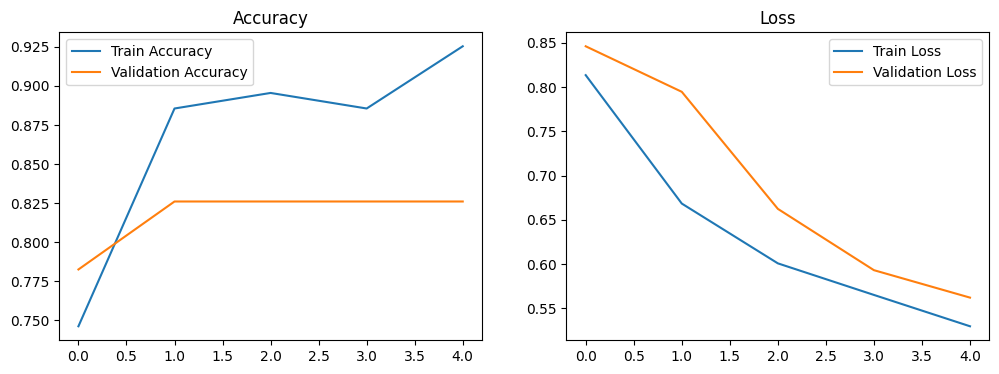

Changed fisher matrix:  [array([[[0.01508281, 0.01487003, 0.01876283, 0.01554088, 0.01904531,
         0.00764407, 0.01847066, 0.01988113, 0.01831879, 0.01986873,
         0.00593964, 0.02435392, 0.01048637, 0.01960723, 0.00696959,
         0.04037191, 0.02483187, 0.0095131 , 0.04348048, 0.03007509,
         0.01685202, 0.006784  , 0.02813491, 0.00791702, 0.01341844,
         0.04462727, 0.00938167, 0.01889983, 0.00485759, 0.00790702,
         0.01385794, 0.01050707, 0.05142152, 0.01744345, 0.03731102,
         0.0369386 , 0.00844987, 0.01522142, 0.01843703, 0.02108801,
         0.01001182, 0.0282183 , 0.0178178 , 0.02873058, 0.01842347,
         0.03080419, 0.01595828, 0.01590213, 0.02938305, 0.04899264,
         0.00941099, 0.02642257, 0.00530842, 0.03769246, 0.02853876,
         0.01500263, 0.01900384, 0.01267525, 0.02678637, 0.00188404,
         0.04489725, 0.03024312, 0.01227715, 0.01180364, 0.01718709,
         0.01004179, 0.01267168, 0.01254995, 0.00950751, 0.04488456,
         

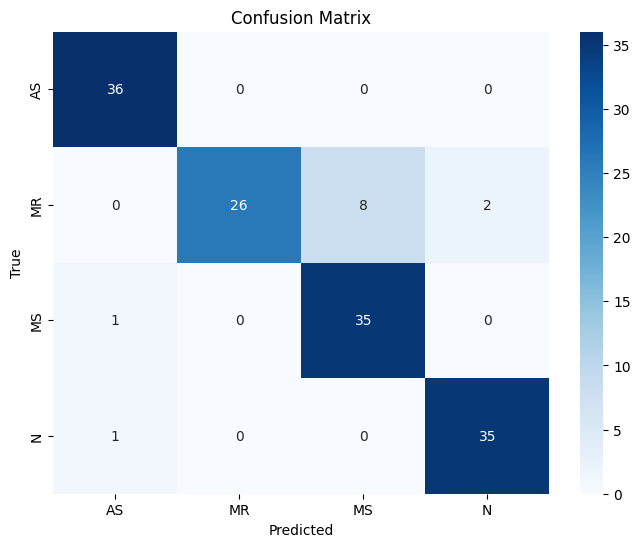

In [8]:
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

incremental_csv_path = r"..\Dataset\inc_audio_mfcc_features_with_labels.csv"

inc_train_x_mfcc, inc_train_y_mfcc, inc_test_mfcc, _, _, _, _, _, upd_label_encoder, _ = SplitDataset(incremental_csv_path, loaded_label_encoder)
print(upd_label_encoder.classes_)
model.train_incremental(inc_train_x_mfcc, np.argmax(inc_train_y_mfcc, axis=1), validation_split=0.1) #use incremental train function.
model.evaluate_model(X_test_mfcc, np.argmax(y_test_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

Skipping SMOTE: Only one class detected in y_train_spectrogram.
Skipping SMOTE: Only one class detected in y_train_mfcc.
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Class Mapping in Label Encoder:
AS: 0
MR: 1
MS: 2
N: 3
MVP: 4
🔹 Combined X_train shape: (151, 13, 1)
🔹 Combined y_train shape: (151, 5)
🔵 Adding new label: Current num_classes = 4, Incrementing by 1.
✅ Old Weights Stored Successfully!
✅ Old Output Layer Weights Retrieved
✅ Created New Output Layer with 5 Classes
🔄 Applying layer 0: conv1d
🔄 Applying layer 1: max_pooling1d
🔄 Applying layer 2: conv1d_1
🔄 Applying layer 3: max_pooling1d_1
🔄 Applying layer 4: flatten
🔄 Applying layer 5: dense
✅ Model Architecture Updated Successfully!
✅ Weights Transferred to Layer: input_layer
✅ Weights Transferred to Layer: conv1d
✅ Weights Transferred to Layer: max_pooling1d
✅ Weights Transferred to Layer: conv1d_1
✅ Weights Transferred to Layer: max_pooling1d_1
✅ Weights Transferred to Layer: flatten
✅ Weights Transferred to Layer: d

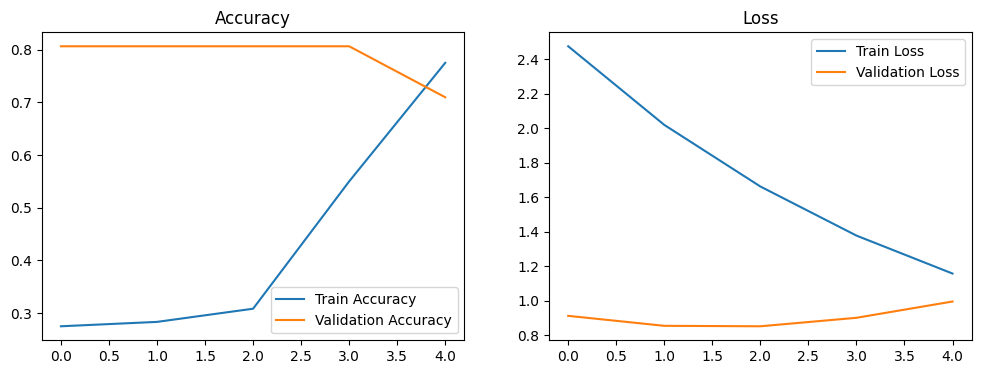

Changed fisher matrix:  [array([[[0.02230214, 0.04235718, 0.02091768, 0.02510624, 0.03464995,
         0.00893502, 0.02521772, 0.04261781, 0.00900135, 0.00398464,
         0.00327974, 0.00516553, 0.01116047, 0.01829378, 0.00727612,
         0.0789692 , 0.02885054, 0.00472485, 0.01976007, 0.01501413,
         0.01006668, 0.00630765, 0.03122158, 0.01311745, 0.00787382,
         0.00913082, 0.01285151, 0.02235815, 0.01294814, 0.00524243,
         0.01694185, 0.00597913, 0.01240672, 0.01837306, 0.06956629,
         0.01820033, 0.01123443, 0.00886345, 0.01935923, 0.01072251,
         0.0052102 , 0.00502066, 0.0257032 , 0.03417256, 0.02275174,
         0.05528857, 0.00319939, 0.01057295, 0.04772509, 0.07333716,
         0.00936642, 0.0200121 , 0.00892721, 0.02859399, 0.0331415 ,
         0.01060699, 0.02616339, 0.00845397, 0.02849867, 0.00937416,
         0.05777555, 0.03163151, 0.0159541 , 0.02302728, 0.00901931,
         0.01276552, 0.01111393, 0.00880144, 0.01665855, 0.03692939,
         

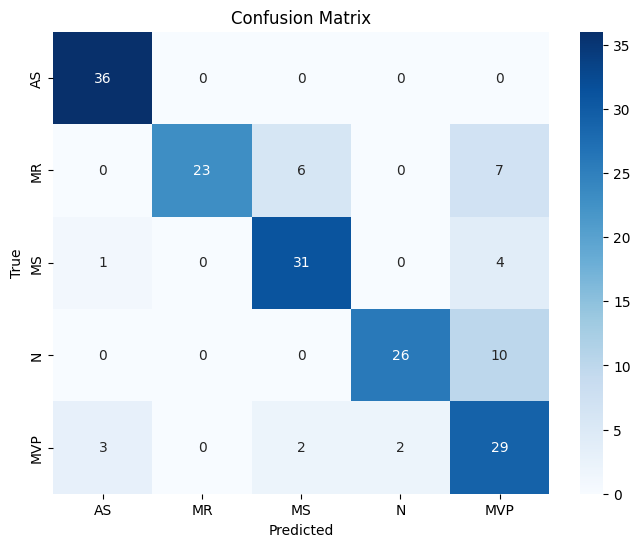

In [9]:
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

mvp_csv_path = r"..\Dataset\continuous_audio_mfcc_features_with_labels.csv"
mvp_train_x_mfcc, mvp_train_y_mfcc, mvp_test_x_mfcc, mvp_test_y_mfcc, _, _, _, _, upd_label_encoder, _ = SplitDataset(mvp_csv_path, loaded_label_encoder)

def sample_data(X, y, sample_ratio=0.3):
    """Randomly selects a percentage of the data."""
    sample_size = int(len(X) * sample_ratio)  # Calculate 20% of the data
    indices = np.random.choice(len(X), sample_size, replace=False)  # Randomly select indices
    return X[indices], y[indices]  # Return sampled data

old_x_train_mfcc,old_y_train_mfcc,old_x_test_mfcc, old_y_test_mfcc, _,_,_,_,upd_label_encoder, _ = SplitDataset(initial_csv_path, upd_label_encoder)
print(old_y_train_mfcc[3])
old_x_sample, old_y_sample = sample_data(old_x_train_mfcc, old_y_train_mfcc, sample_ratio=0.2)

print(old_y_sample[3])
print(old_y_test_mfcc[12])

print("Class Mapping in Label Encoder:")
for class_name, encoded_value in zip(upd_label_encoder.classes_, range(len(upd_label_encoder.classes_))):
    print(f"{class_name}: {encoded_value}")

combined_x_train = np.concatenate((mvp_train_x_mfcc, old_x_sample), axis=0)
combined_y_train = np.concatenate((mvp_train_y_mfcc, old_y_sample), axis=0)

# Debug: Print shapes before training
print(f"🔹 Combined X_train shape: {combined_x_train.shape}")
print(f"🔹 Combined y_train shape: {combined_y_train.shape}")

# Use the combined dataset for incremental learning
model.add_new_label(combined_x_train, np.argmax(combined_y_train, axis=1)) 

# Ensure all arrays are NumPy arrays
print(old_y_test_mfcc[12])
X_combined_test = np.concatenate((old_x_test_mfcc, mvp_test_x_mfcc), axis=0)
y_combined_test = np.concatenate((old_y_test_mfcc, mvp_test_y_mfcc), axis=0)

# Evaluate the model with the combined test set
model.evaluate_model(X_combined_test, np.argmax(y_combined_test, axis=1), upd_label_encoder)

# model.evaluate_model(mvp_test_x_mfcc, np.argmax(mvp_test_y_mfcc, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

In [10]:
# print(old_y_test_mfcc[12])
# print(mvp_test_y_mfcc[13])
# X_combined_test = np.concatenate((old_x_test_mfcc, mvp_test_x_mfcc), axis=0)
# y_combined_test = np.concatenate((old_y_test_mfcc, mvp_test_y_mfcc), axis=0)

# # Evaluate the model with the combined test set
# model.evaluate_model(X_combined_test, np.argmax(y_combined_test, axis=1), upd_label_encoder)

# # model.evaluate_model(mvp_test_x_mfcc, np.argmax(mvp_test_y_mfcc, axis=1), upd_label_encoder)

# with open("label_encoder.pkl", "wb") as f:
#     pickle.dump(upd_label_encoder, f)